<a href="https://colab.research.google.com/github/nik1806/Semantic-segmentation/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# mounting google drive
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# Load the data and organizing it 
# root_dir = 'drive/My Drive/'
# data_dir = root_dir + 'NN_pro_data'

In [3]:
# change directory
# import os
# os.chdir(data_dir)
# !ls

In [4]:
# unzip data 
#!unzip gtFine_trainvaltest.zip
# !unzip leftImg8bit_trainvaltest.zip

In [ ]:
# !ls

gtFine	     leftImg8bit_trainvaltest.zip  license.txt	README_IMG
leftImg8bit  license_img.txt		   README


In [7]:
# Insert the directory - FOR importing user-defined modules/packages
# import sys
# sys.path.insert(0,'/content/drive/My Drive/Semantic-segmentation')

In [104]:
# from dataset import cityscapes_train
# from dataset import cityscapes_val
from torchvision import transforms
from torchvision.datasets import Cityscapes
import numpy as np
import torch
import torchvision.transforms.functional as TF
import random
from matplotlib import pyplot as plt

In [125]:

def pair_transform_train(image, target):
    """
    Perform appropriate transformations on image and segmentation map.
    For segmap, only convert to tensor and apply augmentation, no normalization etc.
    Args:
        image: Original image
        target: Segmentation map
    """
    # transformation for performing augmentation
    resize = transforms.Resize(size=(256, 256))
    image = resize(image)
    target = resize(target)

    # random horizontal flipping
    if(random.random() > 0.4):
        # print("hflip")
        image = TF.hflip(image)
        target = TF.hflip(target)

    # random rotation
    if(random.random() > 0.4):
        angle = random.randint(-10, 10) # angle between -5 to 5 degree
        image = TF.rotate(image, angle)
        target = TF.rotate(target, angle)


    # aug_T = transforms.Compose([
    #     transforms.Resize((128, 128)),
        # transforms.RandomHorizontalFlip(p=0.2),
        # transforms.RandomRotation(10),
        #transforms.CenterCrop(100),
    # ])
    # img, target = aug_T(img), aug_T(target)

    img_T = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])
    
    # transformations particular for image, e.g., normalization
    image = img_T(image)
    target = torch.from_numpy(np.array(target)).long() # convert to tensor
    return image, torch.clamp(target, max=34)
    # return image, target

def pair_transform_val(image, target):
    """
    Perform appropriate transformations on image and segmentation map.
    For segmap, only convert to tensor and apply augmentation, no normalization etc.
    Args:
        image: Original image
        target: Segmentation map
    """
    # transformation for performing augmentation
    resize = transforms.Resize(size=(256, 256))
    image = resize(image)
    target = resize(target)

    # transformations particular for image, e.g., normalization
    img_T = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])
    image = img_T(image)

    target = torch.from_numpy(np.array(target)).long() # convert to tensor
    return image, torch.clamp(target, max=34)

In [126]:
# dst_train = cityscapes_train('.', transform=transformation)
# dst_val = cityscapes_val('.', transform=transformation)


In [127]:
dst_train = Cityscapes(data_dir, split='train', mode='fine', target_type='semantic', transforms=pair_transform_train) # data_dir
dst_val = Cityscapes(data_dir, split='val', mode='fine', target_type='semantic', transforms=pair_transform_val)

In [128]:
# data length
length_train = len(dst_train)
length_val = len(dst_val)
print(length_train)
print(length_val)

2975
500


In [129]:
from utils.inv_transform import unNormalize

(-0.5, 255.5, 255.5, -0.5)

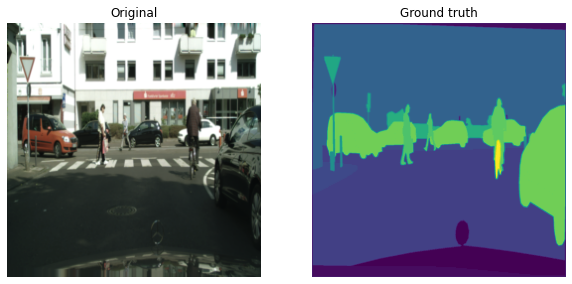

In [131]:
# Verifying transformations (Especially consistancy among image and segmentation map)

# img, segmap = dst_train[16]
img, segmap = dst_val[16]

fig = plt.figure(figsize=(10, 7))

fig.add_subplot(1,2,1)
img = img.data.numpy() # data in image and current form of matrix
img = unNormalize(img, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # unNormalize
img = img.transpose((1,2,0)).astype(np.uint8) # change dtype to correct format for display
plt.title('Original')
plt.imshow(img) # original
plt.axis('off')

# ground truth
fig.add_subplot(1, 2, 2)
label = segmap.data.numpy() # data in image and current form of matrix
# label = decode_segmap(label)
plt.title('Ground truth')
plt.imshow(label) 
plt.axis('off')

In [142]:
from torch.utils.data import DataLoader
bs = 8
#Dataloaders
train_loader = DataLoader(dst_train, batch_size=bs, shuffle=True)
val_loader = DataLoader(dst_val, batch_size=bs,shuffle=True)

In [143]:
dataiter = iter(train_loader)
#print(dataiter.next())
(images, labels) = dataiter.next()

dataiter_val = iter(val_loader)
(images_val, labels_val) = dataiter_val.next()

In [144]:
labels_val.shape

torch.Size([8, 256, 256])

In [134]:
from models.networkT2 import R2UNet

In [135]:
import torch
criterion = torch.nn.CrossEntropyLoss()
device = torch.device("cuda")
model = R2UNet(in_channels=3,n_classes=34).to(device)

In [136]:
from torch.optim import SGD, Adam, lr_scheduler

optimizer = Adam(model.parameters(), 5e-4, (0.9, 0.999),  eps=1e-08, weight_decay=1e-4) 


In [ ]:
loss_train = []
loss_val = []

for epoch in range(1):
    #Training
    model.train()
    running_loss = 0

    for i, (images, labels) in enumerate(train_loader):
        inputs = images.to(device)
        labels = labels.to(device)
        # labels = labels.squeeze(1)
        optimizer.zero_grad()
        outputs = model(inputs)

        #loss = criterion(outputs,targets[:,0])
        #loss = criterion(outputs,labels[:,0].long())
        # loss = criterion(outputs,labels.long())
        loss = criterion(outputs,labels)

        loss.backward()
        optimizer.step()
        ###accumulating loss for each batch
        running_loss += loss.item()

        if i%20 == 0:
            print("epoch{}, iter{}, loss: {}".format(epoch, i, running_loss/(bs*i)))
    loss_train.append(running_loss/len(train_loader))

    # print("epoch{}, loss: {}".format(epoch, running_loss))
    torch.save(model.state_dict(), f'weights/T2/epoch_{i}.pth')

    #Validation
    model.eval()
    running_loss_val = 0
    for i, (images, labels) in enumerate(val_loader):
        inputs = images.to(device)
        labels = labels.to(device)
        # labels = labels.squeeze(1)
             
        with torch.no_grad(): 
            outputs = model(inputs)
            # loss = criterion(outputs,labels.long())
            loss = criterion(outputs,labels)

            ###accumulating loss for each batch
            running_loss_val += loss.item()


        #if i%10 == 0:
    loss_val.append(running_loss_val/len(val_loader))
    print("epoch{}, loss: {}".format(epoch, running_loss_val/len(val_loader)))


epoch0, iter0, loss: 0.2300432026386261
epoch0, iter20, loss: 0.20971424877643585


In [ ]:
# x = [i for i in range(len(train_loader))]
X = range(epochs)
plt.title("Plot showing training and validation loss against number of epochs")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.plot(np.arange(len(loss_train)), loss_train, color='b', label='Training loss')
plt.plot(np.arange(len(loss_val)), loss_val, color='r', label='Validation loss')
plt.legend()
plt.show()
plt.savefig('results/T2_loss_curves.png', bbox_inches='tight')
# plt.plot()

ValueError: x and y must have same first dimension, but have shapes (0,) and (2975,)